<a href="https://colab.research.google.com/github/mori01-22/kennkyu/blob/main/Sample1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/mori01-22/kennkyu/blob/main/Sample1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# タンス検出 (二値分類) ノートブック

このノートブックは、与えられた画像（タンスあり / タンスなし）を識別するための学習・評価・推論パイプラインを示します。主に TensorFlow / Keras の転移学習（MobileNetV2）を利用します。

前提: 画像データはローカルに用意され、以下のようなフォルダ構成になっていることを想定します:

```
data/
  train/
    tansu/        # タンスが写っている画像（約1000枚程度）
    not_tansu/    # タンスが写っていない画像
```

(検証は自動で分割します)

ノート: このノートブックは Colab / ローカルどちらでも動きます。ローカル環境で GPU を使う場合は適切に TensorFlow をインストールしてください。

In [3]:
# 基本的なインポートと設定
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print('TensorFlow version:', tf.__version__)

# 再現性のためのシード設定（任意）
SEED = 123
tf.random.set_seed(SEED)
np.random.seed(SEED)

TensorFlow version: 2.20.0


In [ ]:
# データセットのパスとパラメータ（必要に応じて変更）
data_dir = Path('data/train')  # ここに tansu と not_tansu のフォルダがある想定
# 効果が出やすいので少し大きめに設定（EfficientNet がよりよく働く）
img_size = (240, 240)
batch_size = 32

# ヘルパ: デモ用の簡易画像データを生成（data/demo_train に作成）
def create_demo_data(base_dir, img_size=(224,224), n_per_class=12):
    from PIL import Image, ImageDraw
    base = Path(base_dir)
    (base / 'tansu').mkdir(parents=True, exist_ok=True)
    (base / 'not_tansu').mkdir(parents=True, exist_ok=True)
    w, h = img_size
    for i in range(n_per_class):
        # タンスっぽい四角を描いた画像
        img = Image.new('RGB', (w, h), color=(150, 120, 90))
        d = ImageDraw.Draw(img)
        d.rectangle([int(w*0.2), int(h*0.2), int(w*0.8), int(h*0.9)], fill=(80, 60, 40))
        img.save(base / 'tansu' / f'tansu_{i}.jpg', 'JPEG')
        # タンスなし（丸）画像
        img2 = Image.new('RGB', (w, h), color=(200, 220, 240))
        d2 = ImageDraw.Draw(img2)
        d2.ellipse([int(w*0.3), int(h*0.3), int(w*0.7), int(h*0.7)], fill=(120, 140, 160))
        img2.save(base / 'not_tansu' / f'not_{i}.jpg', 'JPEG')
    print(f'Created demo dataset at: {base.resolve()} (each class: {n_per_class} images)')

# フォルダ存在確認・デモ作成（不足時）
if not data_dir.exists() or not any(p.is_dir() for p in data_dir.iterdir()):
    print('警告: data/train が見つからない、またはクラスフォルダが不足しています。デモ用データを生成します。')
    demo_dir = Path('data/demo_train')
    if not demo_dir.exists() or not any(p.is_dir() for p in demo_dir.iterdir()):
        create_demo_data(demo_dir, img_size=img_size, n_per_class=12)
    data_dir = demo_dir

# クラスフォルダ数の確認（label_mode='binary' の場合は 2 クラス必須）
subdirs = [p.name for p in data_dir.iterdir() if p.is_dir()]
print('Found class folders:', subdirs)
if len(subdirs) < 2:
    raise ValueError(f'二値分類には少なくとも2つのクラスフォルダが必要です。見つかったクラス: {subdirs}')

# データ読み込み (80% training, 20% validation) - TensorFlow のユーティリティを使用
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',
    validation_split=0.2,
    subset='training',
    seed=SEED,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print('Classes:', class_names)


警告: data/train が見つからない、またはクラスフォルダが不足しています。デモ用データを生成します。
Found class folders: ['not_tansu', 'tansu']
Found 24 files belonging to 2 classes.
Using 20 files for training.
Using 20 files for training.


Found 24 files belonging to 2 classes.
Using 4 files for validation.
Using 4 files for validation.
Classes: ['not_tansu', 'tansu']
Classes: ['not_tansu', 'tansu']


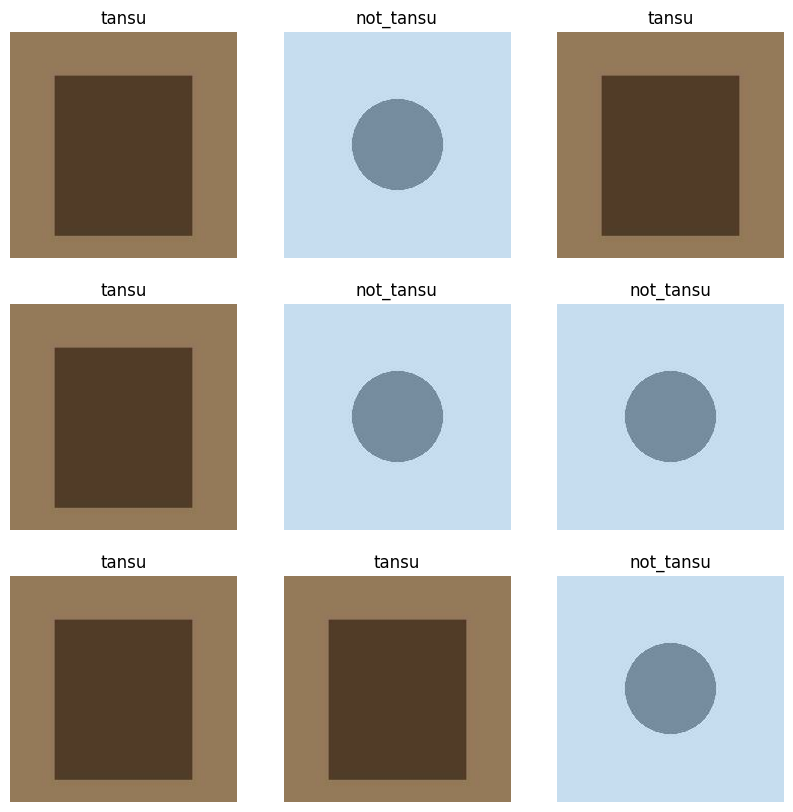

In [5]:
# パフォーマンス最適化: キャッシュとプリフェッチ
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# サンプル画像を表示して確認
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[int(labels[i])])
        plt.axis('off')
plt.show()

In [ ]:
# モデル構築: 転移学習 (EfficientNetB0 を優先) + 強化したヘッド
# データ拡張レイヤーを定義（モデル作成前に必ず定義してください）
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.08),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomZoom(0.05),
    layers.RandomContrast(0.05)
], name='data_augmentation')

# バックボーンを選択し、それに合わせて preprocess_input を設定
try:
    base_model = tf.keras.applications.EfficientNetB0(
        input_shape=img_size + (3,),
        include_top=False,
        weights='imagenet')
    from tensorflow.keras.applications.efficientnet import preprocess_input as _eff_preprocess
    preprocess_input = _eff_preprocess
    print('Using EfficientNetB0 as backbone')
except Exception:
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=img_size + (3,),
        include_top=False,
        weights='imagenet')
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as _mb_preprocess
    preprocess_input = _mb_preprocess
    print('EfficientNet not available; using MobileNetV2 as backbone')

base_model.trainable = False  # まずは凍結してヘッドのみ学習

inputs = keras.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

# 損失関数: ラベルスムージングまたは Focal Loss（オプション）を使えるようにする
# use_focal を True にすると Focal Loss を使用。デフォルトは False（ラベルスムージング付き BCE）
use_focal = False

def binary_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1. - 1e-7)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_factor = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        focal = -alpha_factor * tf.pow(1. - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(focal)
    return loss

if use_focal:
    loss_fn = binary_focal_loss(gamma=2.0, alpha=0.25)
    print('Using Focal Loss for training')
else:
    loss_fn = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.03)
    print('Using BinaryCrossentropy with label smoothing')

# 初期コンパイル（ヘッド学習前の簡易コンパイル）
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=loss_fn,
              metrics=['accuracy'])

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 86s 5us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 86s 5us/step
Using EfficientNetB0 as backbone
Using EfficientNetB0 as backbone


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,055,972 (15.47 MB)

 Trainable params: 3,841 (15.00 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [ ]:
# コールバック: 早期終了、ReduceLROnPlateau、TensorBoard、モデル保存
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
    keras.callbacks.ModelCheckpoint('best_tansu_model.h5', save_best_only=True),
    keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=1),
]

# MixUp の実装（バッチ内でシャッフルして混合）
import tensorflow as _tf
def _sample_beta(alpha, shape):
    # approximate Beta by gamma sampling
    x = _tf.random.gamma(shape, alpha)
    y = _tf.random.gamma(shape, alpha)
    return x / (x + y)

def mixup_batch(images, labels, alpha=0.12):
    batch_size = _tf.shape(images)[0]
    lam = _sample_beta(alpha, [batch_size])
    lam_x = _tf.reshape(lam, [-1,1,1,1])
    lam_y = _tf.reshape(lam, [-1,1])
    idx = _tf.random.shuffle(_tf.range(batch_size))
    images2 = _tf.gather(images, idx)
    labels2 = _tf.gather(labels, idx)
    mixed_x = images * lam_x + images2 * (1 - lam_x)
    mixed_y = labels * lam_y + labels2 * (1 - lam_y)
    return mixed_x, mixed_y

# 訓練用データに MixUp を適用（任意、GPU での学習が推奨）
try:
    mixup_alpha = 0.12
    train_ds_mix = train_ds.map(lambda x,y: mixup_batch(x, tf.expand_dims(y, -1), alpha=mixup_alpha),
                                num_parallel_calls=AUTOTUNE)
    train_ds_mix = train_ds_mix.prefetch(AUTOTUNE)
    ds_to_train = train_ds_mix
    print('Applied MixUp to train dataset (alpha=', mixup_alpha, ')')
except Exception as e:
    print('Could not apply MixUp, falling back to original dataset:', e)
    ds_to_train = train_ds

# クラス不均衡対応: data_dir 配下を数えて class_weight を自動計算
try:
    counts = {}
    for cls in class_names:
        p = Path(data_dir)/cls
        counts[cls] = len(list(p.glob('*'))) if p.exists() else 0
    print('Class counts:', counts)
    total = sum(counts.values())
    n_classes = len(class_names)
    class_weight = {}
    for i, cls in enumerate(class_names):
        cnt = counts[cls]
        class_weight[i] = (total / (n_classes * cnt)) if cnt > 0 else 1.0
    print('Computed class_weight:', class_weight)
except Exception as e:
    print('Could not compute class weights from data_dir:', e)
    class_weight = None

# --- ヘッド学習 ---
# エポック数を増やし、CosineDecay スケジュールを利用して学習
epochs = 20

# Cosine 学習率スケジュールを作成（データ数に応じて decay_steps を自動推定）
initial_lr = 1e-4
try:
    steps = tf.data.experimental.cardinality(ds_to_train).numpy()
    decay_steps = max(1, steps * epochs)
except Exception:
    decay_steps = epochs * 100
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_lr, decay_steps)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])

history = model.fit(ds_to_train, validation_data=val_ds, epochs=epochs, callbacks=callbacks, class_weight=class_weight)

# --- 自動ファインチューニング: ベースモデルの一部を凍結解除して微調整 ---
try:
    print('Starting fine-tuning: unfreezing top layers of the base model...')
    base_model.trainable = True
    # fine_tune_at を調整してどの層から凍結解除するか決める
    fine_tune_at = 100
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # 再コンパイル: ファインチューニングは通常 SGD(momentum) の方が安定する
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),
                  loss=loss_fn,
                  metrics=['accuracy'])

    fine_epochs = 10
    total_epochs = epochs + fine_epochs
    fine_callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint('best_tansu_model_finetuned.h5', save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)
    ]

    fine_history = model.fit(ds_to_train,
                             validation_data=val_ds,
                             epochs=total_epochs,
                             initial_epoch=epochs,
                             callbacks=fine_callbacks,
                             class_weight=class_weight)
except Exception as e:
    print('Fine-tuning skipped or failed:', e)

Applied MixUp to train dataset (alpha= 0.12 )
Class counts: {'not_tansu': 12, 'tansu': 12}
Computed class_weight: {0: 1.0, 1: 1.0}
Epoch 1/12
Epoch 1/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.1225 - loss: 1.0885

1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step - accuracy: 0.1225 - loss: 1.0885 - val_accuracy: 0.0000e+00 - val_loss: 0.9131 - learning_rate: 1.0000e-04
Epoch 2/12
Epoch 2/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.0675 - loss: 1.4594

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.0675 - loss: 1.4594 - val_accuracy: 0.0000e+00 - val_loss: 0.9088 - learning_rate: 1.0000e-04
Epoch 3/12
Epoch 3/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.1250 - loss: 0.9147

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.1250 - loss: 0.9147 - val_accuracy: 0.0000e+00 - val_loss: 0.9042 - learning_rate: 1.0000e-04
Epoch 4/12
Epoch 4/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.0725 - loss: 1.4348

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0725 - loss: 1.4348 - val_accuracy: 0.0000e+00 - val_loss: 0.8998 - learning_rate: 1.0000e-04
Epoch 5/12
Epoch 5/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0700 - loss: 1.2331

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.0700 - loss: 1.2331 - val_accuracy: 0.0000e+00 - val_loss: 0.8954 - learning_rate: 1.0000e-04
Epoch 6/12
Epoch 6/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.1725 - loss: 0.9310

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.1725 - loss: 0.9310 - val_accuracy: 0.0000e+00 - val_loss: 0.8911 - learning_rate: 1.0000e-04
Epoch 7/12
Epoch 7/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 981ms/step - accuracy: 0.2700 - loss: 0.9406

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.2700 - loss: 0.9406 - val_accuracy: 0.0000e+00 - val_loss: 0.8868 - learning_rate: 1.0000e-04
Epoch 8/12
Epoch 8/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.2300 - loss: 1.1374

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.2300 - loss: 1.1374 - val_accuracy: 0.0000e+00 - val_loss: 0.8825 - learning_rate: 1.0000e-04
Epoch 9/12
Epoch 9/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.2200 - loss: 1.0722

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.2200 - loss: 1.0722 - val_accuracy: 0.0000e+00 - val_loss: 0.8783 - learning_rate: 1.0000e-04
Epoch 10/12
Epoch 10/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1725 - loss: 1.2844

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.1725 - loss: 1.2844 - val_accuracy: 0.0000e+00 - val_loss: 0.8741 - learning_rate: 1.0000e-04
Epoch 11/12
Epoch 11/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.1725 - loss: 1.1188

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.1725 - loss: 1.1188 - val_accuracy: 0.0000e+00 - val_loss: 0.8698 - learning_rate: 1.0000e-04
Epoch 12/12
Epoch 12/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.1750 - loss: 1.0845

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.1750 - loss: 1.0845 - val_accuracy: 0.0000e+00 - val_loss: 0.8653 - learning_rate: 1.0000e-04
Starting fine-tuning: unfreezing top layers of the base model...
Epoch 13/18
Starting fine-tuning: unfreezing top layers of the base model...
Epoch 13/18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.2000 - loss: 1.7048

1/1 ━━━━━━━━━━━━━━━━━━━━ 39s 39s/step - accuracy: 0.2000 - loss: 1.7048 - val_accuracy: 0.0000e+00 - val_loss: 0.8656 - learning_rate: 1.0000e-05
Epoch 14/18
Epoch 14/18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.5000 - loss: 0.9758

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 0.9758 - val_accuracy: 0.0000e+00 - val_loss: 0.8646 - learning_rate: 1.0000e-05
Epoch 15/18
Epoch 15/18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.5500 - loss: 0.9856

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5500 - loss: 0.9856 - val_accuracy: 0.0000e+00 - val_loss: 0.8638 - learning_rate: 1.0000e-05
Epoch 16/18
Epoch 16/18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.5000 - loss: 0.9411

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 0.9411 - val_accuracy: 0.0000e+00 - val_loss: 0.8621 - learning_rate: 1.0000e-05
Epoch 17/18
Epoch 17/18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.5000 - loss: 0.8686

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 0.8686 - val_accuracy: 0.0000e+00 - val_loss: 0.8599 - learning_rate: 1.0000e-05
Epoch 18/18
Epoch 18/18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.7500 - loss: 0.6325

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7500 - loss: 0.6325 - val_accuracy: 0.0000e+00 - val_loss: 0.8577 - learning_rate: 1.0000e-05


In [9]:
# モデル保存 — Keras ネイティブ形式（推奨）と SavedModel（TFLite/TF Serving 用）を両方試す
try:
    # Keras ネイティブ形式（単一ファイル）
    model.save('tansu_detector.keras')
    print('モデルを tansu_detector.keras に保存しました (Keras native format)')
except Exception as e:
    print('Keras native save failed:', e)


モデルを tansu_detector.keras に保存しました (Keras native format)
